In [5]:
def get_object_detection_model(num_classes):
    from torch import nn
    import torchvision
    from torchvision.models.detection import FasterRCNN
    from torchvision.models.detection.rpn import AnchorGenerator
    from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
    
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn()
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes) # lenght of classes WITHOUT background on input
    
#    model.roi_heads.box_predictor.cls_score = nn.Sequential(nn.Linear(1024, 512), nn.Linear(512,256), nn.Linear(256, 128), nn.Linear(128, 2))
    
#    model.roi_heads.box_predictor.bbox_pred = nn.Sequential(nn.Linear(1024, 512), nn.Linear(512,256), nn.Linear(256, 128), nn.Linear(128, 8))

    return model


def load_model(filepath: str):   
    model = get_object_detection_model(num_classes=2)
    model.load_state_dict(torch.load(filepath))
    return model

def eval_transform():
    from albumentations import Compose, ToFloat
    from albumentations.pytorch import ToTensorV2    
    return Compose([ToFloat(p=1.0), ToTensorV2(p=1.0)])

import torch
@torch.no_grad()
def predict_images(filepath, model) -> None:
    import os
    import cv2
    import pandas as pd
    import numpy as np
    from torchvision.utils import draw_bounding_boxes, save_image
    from tqdm import tqdm
    
    inv_classes = {value:key for key, value in classes.items()}    
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')   
    model.to(device)  
    images = [image for image in os.listdir(filepath) if image.endswith('.JPG')]
#    print(images)
    for im in tqdm(images):
        image_orig = cv2.imdecode(np.fromfile(filepath + '/' + im, dtype=np.uint8), cv2.IMREAD_UNCHANGED) #cv2.imread(filepath + '/' + im)  
        image = cv2.cvtColor(image_orig, cv2.COLOR_BGR2RGB)
        transform = eval_transform()        
        model.eval()       
        x = transform(image=image)       
        x = x['image']        
        x = x[:3, ...].to(device)        
        predictions = model([x, ])        
        pred = predictions[0]
        pred = cut_score_V2(predictions=pred, device=device, score_thresh=0.95)
#        print(f"Scores for image {im} is in [{pred['scores']}]")
        df = pd.DataFrame(data=pred['boxes'], columns=['xmin', 'ymin', 'xmax', 'ymax'])
        df['label'] = [inv_classes[label] + f': {round(score, 2)}' for label, score in zip(pred['labels'], pred['scores'])]
        for num, rect in enumerate(df.itertuples()):
            xmin = int(torch.FloatTensor.item(rect.xmin.detach().cpu())) - 50
            xmax = int(torch.FloatTensor.item(rect.xmax.detach().cpu())) + 50
            ymin = int(torch.FloatTensor.item(rect.ymin.detach().cpu())) - 50
            ymax = int(torch.FloatTensor.item(rect.ymax.detach().cpu())) + 50
            
            if xmin < 0:
                xmin = 0
            if ymin < 0:
                ymin = 0
                
            if xmax > image_orig.shape[1] - 1:
                xmax = image_orig.shape[1] - 1
            if ymax > image_orig.shape[0] - 1:
                ymax = image_orig.shape[0] - 1
            
            start_point = (xmin, ymax) 
            end_point = (xmax, ymin)
#            print(start_point, end_point)
            color = (0, 0, 255) 
            thickness = 5
            crop_image = image_orig[ymin:ymax, xmin:xmax, :]

#            try:
#                cv2.imwrite(f'./test_pred_1/{im[:-4]}_crop_{num}.jpg', crop_image)
#            except Exception as e:
#                print(f'Image: {im}; xmin={xmin}, xmax={xmax}, ymin={ymin}, ymax={ymax}')
#                raise e
            #cv2.rectangle(image_orig, start_point, end_point, color, thickness)
            #cv2.putText(image_orig, f'Box_{num}', (xmin, ymin - 10), cv2.FONT_HERSHEY_SIMPLEX, 2, (0,0,255), 3, cv2.LINE_AA)
            #try:
            annotate(im, image, crop_image, xmin, xmax, ymin, ymax, filepath, num)
            #except:
                #print(f'annotaton skip at {im}')
            # Displaying the image  
            cv2.imwrite(f'./NEW_DATASET/2c_dataset/temp/{im[:-4]}_MalMich_auto_crop_{num}.jpg', crop_image)  

        
def cut_score_V2(predictions: dict, device, score_thresh = 0.5):
    new_pred = {'boxes': [], 'labels': [], 'scores': []}
    for box, label, score in zip(predictions['boxes'], predictions['labels'], predictions['scores']):
        if score >= score_thresh:
            new_pred['boxes'].append(box)
            new_pred['labels'].append(torch.IntTensor.item(label))
            new_pred['scores'].append(torch.FloatTensor.item(score))
    return new_pred

def annotate(image_name, image, crop_image, xmin, xmax, ymin, ymax, path, num):
    points = []
    with open(path[:-7] + '/Extracted_Points/annotations/' + image_name[:-4] + '_extr.txt', 'r') as f:
        for line in f:
            line = line.split()
            x, y = map(float, line[1:3])
            if xmin < int(x * image.shape[1]) < xmax and ymin < int(y * image.shape[0]) < ymax:
                points.append([(int(x * image.shape[1]) - xmin) / crop_image.shape[1], (int(y * image.shape[0]) - ymin) / crop_image.shape[0]])
    with open(f'./NEW_DATASET/2c_dataset/temp/annotations/{image_name[:-4]}_MalMich_auto_crop_{num}.txt', 'w') as file:
        for point in points:
            file.write(f'0 {point[0]:.6f} {point[1]:.6f} {20/crop_image.shape[1]:.6f} {20/crop_image.shape[0]:.6f}\n')

In [6]:
model_path = "C:/Users/User/Desktop/Teobox_Ship_2022-10-16T21.03.14/NN_models/Building_detection_model.pth"
classes = {'Building': 1}
path = "C:/Users/User/Desktop/д. Малая Михайловка/images"

model = load_model(model_path)

predict_images(path, model)
#print(model.backbone)

100%|██████████| 305/305 [09:06<00:00,  1.79s/it]


In [6]:
if ...:
    print('g')

g


In [9]:
s = 'Bachar (1).tif'

''.join(im[:-4].split())

'Bachar(1)'

In [11]:
num = 1

f'./snow_test_pred_2/{"".join(s[:-4].split())}_snow_2_crop_{num}.jpg'

'./snow_test_pred_2/Bachar(1)_snow_2_crop_1.jpg'

In [16]:
class MyClass():
    def __init__(self, a, b, **kwargs):
        self.a = a
        self.b = b
        self.arr = kwargs
    def get_kwargs(self):
        return self.arr

test = MyClass(a=1, b=2, c='lol', d='kek', e=31, f=33)

In [21]:
test.get_kwargs().items()

dict_items([('c', 'lol'), ('d', 'kek'), ('e', 31), ('f', 33)])

In [22]:
[1.0] * 5

[1.0, 1.0, 1.0, 1.0, 1.0]

In [24]:
import torch

class_weights = [1.0] * 5

class_weights = torch.as_tensor(class_weights, dtype=torch.float32)

In [25]:
class_weights

tensor([1., 1., 1., 1., 1.])

In [28]:
import shutil
import os

path = "C:/Users/User/Petr/Net_3/Dataset"

images = os.listdir(os.path.join(path, "temp"))

for image in images:
    os.rename(os.path.join(path, "temp", image), os.path.join(path, "temp", image[:-4] + '_Mar' + image[-4:]))
        

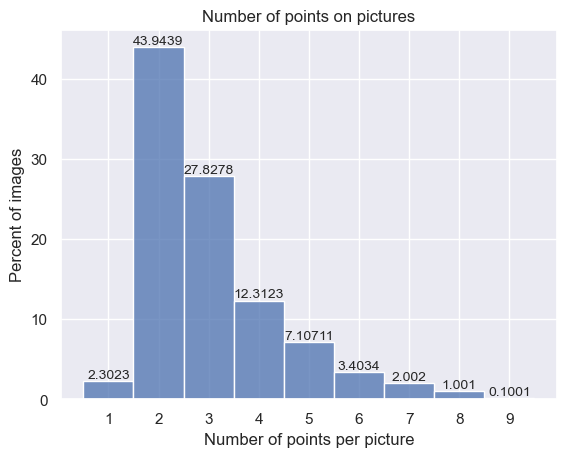

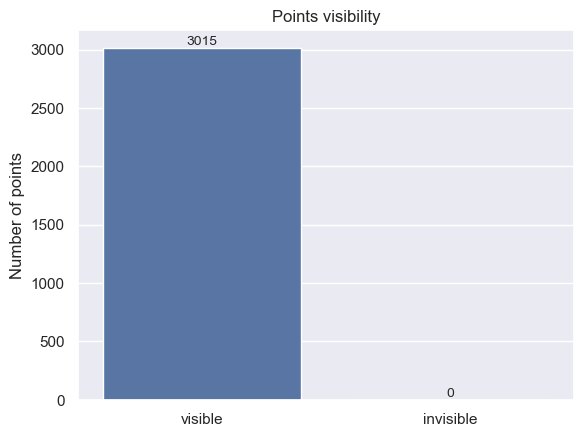

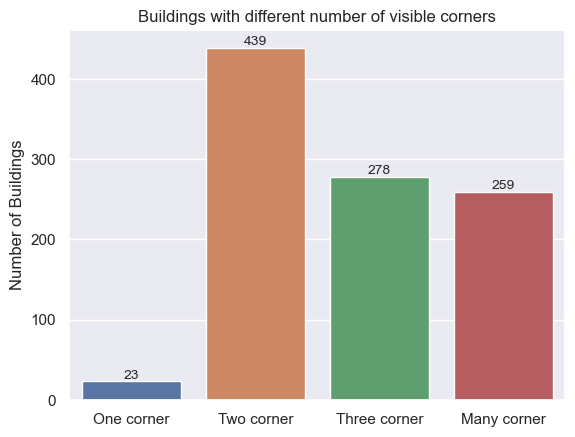

Files without buildings:




In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
annotations_files = [file for file in sorted(os.listdir(os.path.join('./NEW_DATASET', "annotations"))) if not file=='classes.txt']

max_lines = 0
nums_of_points = []
point_visibility = {'visible': 0, 'invisible': 0}
buildings = {'One corner': 0, 'Two corner': 0, 'Three corner': 0, 'Many corner': 0}
#two_corner_files = []
#three_corners_files = []
files_without_buildings = []
for file in annotations_files: 
    with open(os.path.join('./NEW_DATASET', "annotations/") + file, 'r') as f:
        visible_points = 0
        lines = f.readlines()
        sum_p = 0
        building_marked = False
        for line in lines:
            if int(line.split()[0]) in (0, 1):
                sum_p += 1
            if int(line.split()[0]) == 0:
                visible_points += 1
            if int(line.split()[0]) == 2:
                building_marked = True
        if not building_marked:
            files_without_buildings.append(file)
        if sum_p == 10:
            print(file)
        nums_of_points.append(sum_p)
        for line in lines:
            if line.startswith('0'):
                point_visibility['visible'] += 1
            elif line.startswith('1'):
                point_visibility['invisible'] += 1
                print(file)
        if visible_points == 1:
            buildings['One corner'] += 1
            #print(file)
        elif visible_points == 2:
            buildings['Two corner'] += 1
            #two_corner_files.append(file[:-4]) 
        elif visible_points == 3:
            buildings['Three corner'] += 1
            #three_corners_files.append(file[:-4])
        else:
            buildings['Many corner'] += 1
            #print(file)
    
            
import seaborn as sns

sns.set_theme()

NPoints_hist = sns.histplot(nums_of_points, discrete=True, kde=False, stat='percent')
#NPoints_hist.bar_label(NPoints_hist.containers[0], fontsize=10)
NPoints_hist.set_title('Number of points on pictures')
NPoints_hist.set_xlabel('Number of points per picture')
NPoints_hist.set_ylabel('Percent of images')
NPoints_hist.set(xticks=np.arange(1,10,1))
for container in NPoints_hist.containers:
    NPoints_hist.bar_label(container, fontsize=10)

plt.show()

visibility = sns.barplot(x=list(point_visibility.keys()), y=list(point_visibility.values()))
visibility.bar_label(visibility.containers[0], fontsize=10)
visibility.set_title('Points visibility')
visibility.set_ylabel('Number of points')
plt.show()

buildings_corners = sns.barplot(x=list(buildings.keys()), y=list(buildings.values()))
buildings_corners.bar_label(buildings_corners.containers[0], fontsize=10)
buildings_corners.set_title('Buildings with different number of visible corners')
buildings_corners.set_ylabel('Number of Buildings')
plt.show()

print('Files without buildings:\n')
print(*files_without_buildings)

In [1]:
for i in range(54):
    if i % 10 == 0:
        print(i)

0
10
20
30
40
50


In [4]:
line = '  9 6 7  9    3'

numbers = sum(map(int, line.split()))
print(numbers)

34


In [3]:
point = [23, 40]
width, height = 100, 100

x_c, y_c = [a/b for a, b in zip(point, [width, height])]

w, h = [5/a for a in [width, height]]

print(x_c, y_c, w, h)

0.23 0.4 0.05 0.05
